In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import segpath2path, pairwise_distances, point2segments
from analysis_by_plot import myboxplot, myttests

In [2]:
record_dir = 'gridsearch-routefollow'
var_name = 'rot_coeff'
ls_value = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50
n_condition = len(ls_value)
catchment_radius = 0.372 / 2 ## 0.372 is the wheel axle length of Freight

n_trial = 100
n_epoch_train, n_epoch_test = 125, 500
goal_idx = -1
ls_model_keys = 'pure-pursuit', 'lamb', 'klino'
ls_model_name = 'pure-pursuit', 'differential-MB', 'klinokinesis-MB'
ls_color = 'tab:blue', 'tab:green', 'tab:red'# 'tab:orange'
n_model = len(ls_model_name)

In [3]:
data_path = np.load(os.path.join('records', record_dir, 'data_path.npy'), allow_pickle=True)[()]

In [4]:
data_dist_test2goal, data_min_dist2goal, data_time_min_dist2goal = {}, {}, {}
data_dist_testtrunc2goal = {}
data_time_catchment = {}

for model_name in ls_model_name:
    data_path[model_name]['test'] = (data_path[model_name]['test'].T - data_path[model_name]['test'][:, :, :, 0].T).T
    path_train_init = data_path[model_name]['train'][:, :, :, 0]
    data_path[model_name]['train'] = (data_path[model_name]['train'].T - path_train_init.T).T
    path_train_goal = data_path[model_name]['train'][:, :, :, -1]
    dist_init2goal = np.linalg.norm(path_train_goal, axis=-1)
    dist_test2goal = np.linalg.norm(path_train_goal[:, :, :, np.newaxis] - data_path[model_name]['test'], axis=2)
    time_min_dist2goal = np.nanargmin(dist_test2goal, axis=2)
    min_dist2goal = np.nanmin(dist_test2goal, axis=2)
    
    data_dist_test2goal[model_name] = dist_test2goal
    data_min_dist2goal[model_name] = min_dist2goal
    data_time_min_dist2goal[model_name] = time_min_dist2goal
    
    nan_mask = (time_min_dist2goal.T < np.tile(np.arange(n_epoch_test), (n_condition, n_trial, 1)).T).T
    nan_mask_path = np.moveaxis(np.tile(nan_mask, (2, 1, 1, 1)), 0, 2)
    data_dist_testtrunc2goal[model_name] = np.where(nan_mask, np.nan, dist_test2goal)
    data_path[model_name]['test_trunc'] = np.where(nan_mask_path, np.nan, data_path[model_name]['test'])

    time_catchment = np.argmax(dist_test2goal <= catchment_radius, axis=-1)
    data_time_catchment[model_name] = np.where(time_catchment == 0, np.nan, time_catchment)

In [5]:
data_dsim_test2train, data_dist_test2path = {}, {}

for model_name in ls_model_name:
    model_dsim_test2train, model_dist_test2path = [], []
    for path_train_val, path_test_val, time_mindist_test2goal_val in zip(data_path[model_name]['train'], 
                                                                          data_path[model_name]['test_trunc'],
                                                                          data_time_min_dist2goal[model_name]):
        val_time_mindist = []
        val_dist_test2path = np.full((n_trial, n_epoch_test), np.nan)
        for trial_idx, (path_train_trial, path_test_trial, time_mindist) in enumerate(zip(path_train_val, 
                                                                                        path_test_val, 
                                                                                        time_mindist_test2goal_val)):
            dsim_test2train, dist_test2path = segpath2path(path_test_trial.T[:time_mindist + 1], path_train_trial.T)
            val_time_mindist.append(dsim_test2train)
            val_dist_test2path[trial_idx, :time_mindist + 1] = dist_test2path
        model_dsim_test2train.append(val_time_mindist)
        model_dist_test2path.append(val_dist_test2path)
        
    data_dsim_test2train[model_name] = np.array(model_dsim_test2train)
    data_dist_test2path[model_name] = np.array(model_dist_test2path)

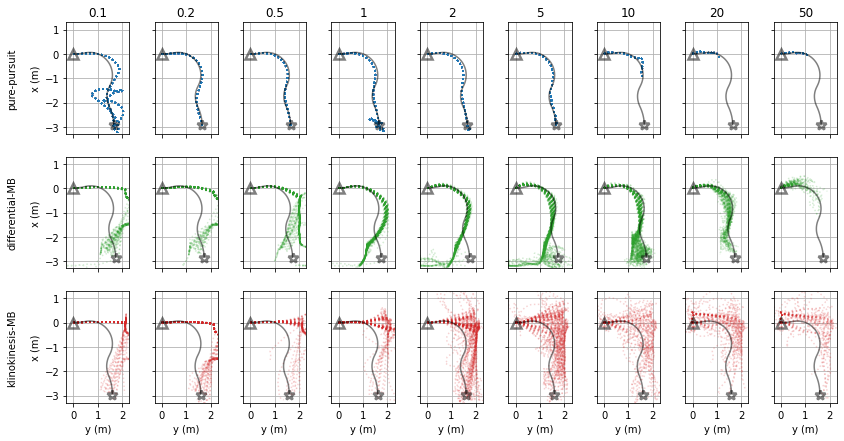

In [16]:
fig, axes = plt.subplots(n_model, n_condition, sharex=True, sharey=True, figsize=(14, 7))

for model_name, axrow, color in zip(ls_model_name, axes, ls_color):
    for dtp_train, dtp_testtrunc, val, ax in zip(data_path[model_name]['train'], 
                                                            data_path[model_name]['test_trunc'],
                                                            ls_value, axrow):
        for trial_idx, (path_train, path_test_trunc) in enumerate(zip(dtp_train, dtp_testtrunc)):
            if trial_idx % 1 == 0:
                ax.plot(*path_test_trunc, c=color, alpha=0.2, ls='dotted')
        
        ax.plot(*path_train[:, :goal_idx], c='k', alpha=0.5)
        ax.plot(*path_train[:, 0], marker='^', c='k', mfc='none', markersize=10, markeredgewidth=lw/2, alpha=0.5)
        ax.plot(*path_train[:, goal_idx], marker='*', c='k', mfc='none', markersize=10, markeredgewidth=lw/2, alpha=0.5)


    
for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlim(-0.3, 2.3)
    ax.set_ylim(-3.3, 1.3)
    ax.set_xticks([0, 1, 2])
    
for ax, val in zip(axes[0], ls_value):
    ax.set_title(val)

for ax in axes[-1]:
    ax.set_xlabel('y (m)')
    
for ax, model_name in zip(axes.T[0], ls_model_name):
    ax.set_ylabel('{}\n\nx (m)'.format(model_name))

<ipython-input-7-8296b6070ea1>:46: RuntimeWarning: Mean of empty slice
  ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-7-8296b6070ea1>:54: RuntimeWarning: Mean of empty slice
  cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packa

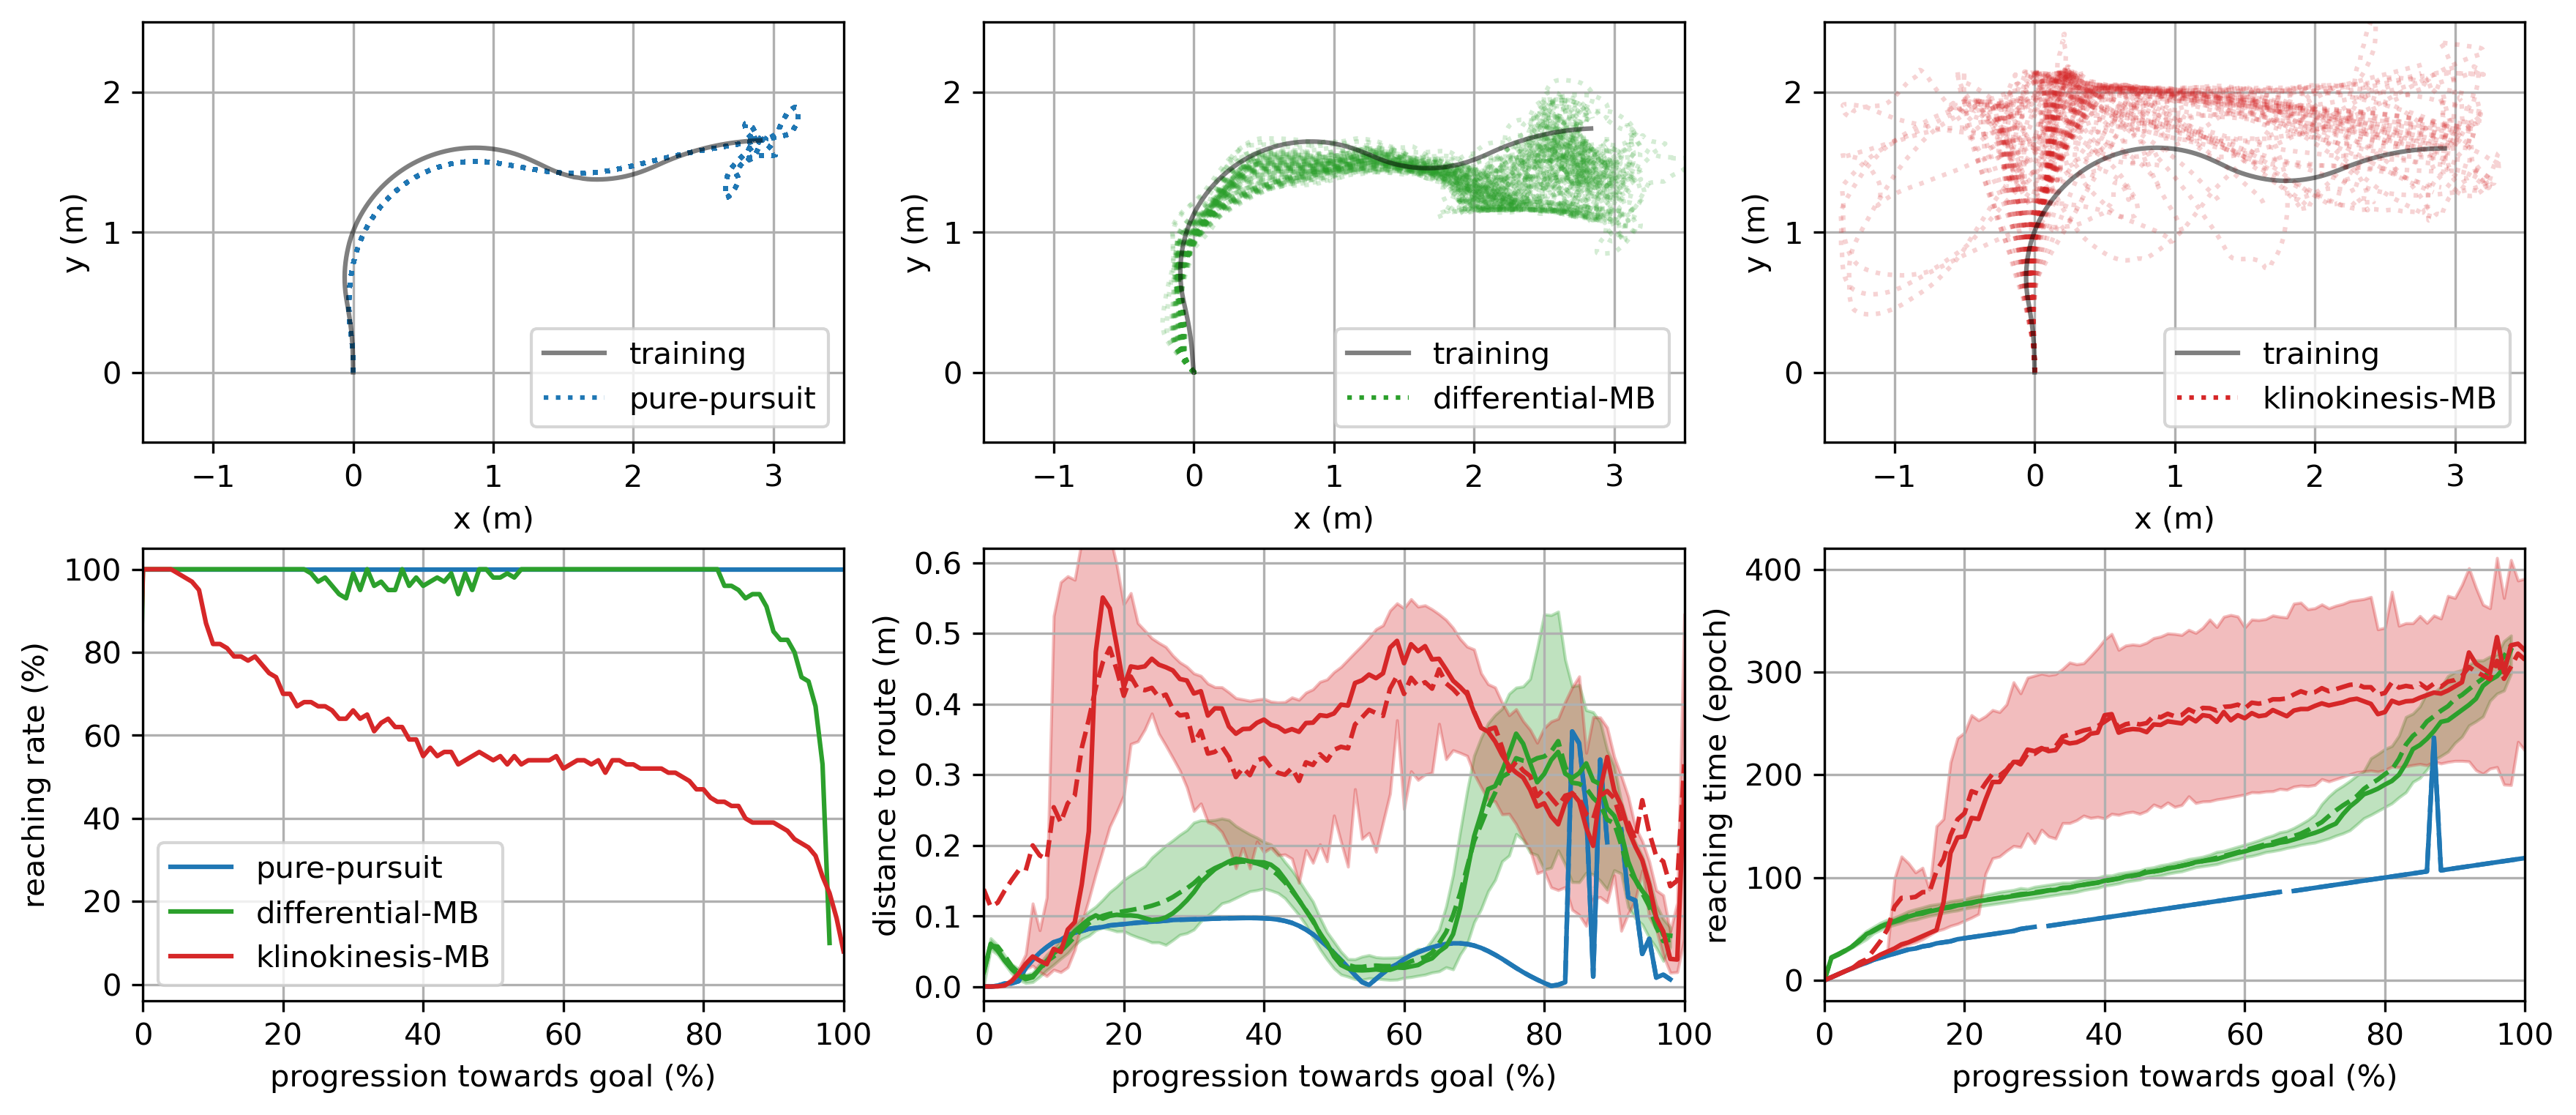

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex='row', dpi=300)

ls_validx = 3, 6, 4


for model_name, ax, color, validx in zip(ls_model_name, axes[0], ls_color, ls_validx):
    dtp_train, dtp_test, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('train', 'test', 'test_trunc')]
    for trial_idx, (path_train, path_test, path_test_trunc) in enumerate(zip(dtp_train, dtp_test, dtp_test_trunc)):
        if trial_idx % 1 == 0:
            ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.2, ls='dotted')

    ax.plot(-path_train[:, :goal_idx][1], path_train[:, :goal_idx][0], c='k', alpha=0.5, label='training')
    ax.plot([], [], c=color, ls='dotted', label=model_name)

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xticks(np.arange(-1, 3.1, 1))
    ax.set_yticks(np.arange(0, 2.1, 1))
    ax.set_xlim(-1.5, 3.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')    
    ax.legend(loc=4)
    ax.grid()


bx, ax, cx = axes[1]
for model_name, color, validx in zip(ls_model_name, ls_color, ls_validx):
    dist_test2goal, dist_test2path = data_dist_test2goal[model_name][validx], data_dist_test2path[model_name][validx]
    progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
    progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

    val_test2path, val_n_point = [], []
    val_ptime = []
    for trial_progress, trial_test2path in zip(progress, dist_test2path):
        px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
        pxinvsort = np.argsort(pxinv)
        t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort], left=np.nan, right=np.nan)
        val_test2path.append(t2p_interp)
        val_n_point.extend(px)

        ptime = np.full_like(progress_step, np.nan)
        ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
        val_ptime.append(ptime)


    ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
    ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)

    ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)

    p_reach, n_reach = np.unique(val_n_point, return_counts=True)
    bx.plot(p_reach, n_reach, color=color, label=model_name)

    cx.plot(progress_step, np.nanmean(val_ptime, axis=0), color=color, ls='dashed')
    cx.plot(progress_step, np.nanmedian(val_ptime, axis=0), color=color)
    cx.fill_between(progress_step, *np.nanquantile(val_ptime, (0.25, 0.75), axis=0), color=color, alpha=0.3)
        
for ax, yl in zip(axes[1], ('reaching rate (%)', 'distance to route (m)', 'reaching time (epoch)')):
    ax.set_xlim(0, 100)
    ax.grid()
    ax.set_ylabel(yl)
    ax.set_xlabel('progression towards goal (%)')


axes[1, 0].legend()
    
axes[1, 2].set_ylim(-20, 420)
axes[1, 2].set_yticks(np.arange(0, 401, 100))
axes[1, 1].set_ylim(-0.02, 0.62)
axes[1, 1].set_yticks(np.arange(0, 0.61, 0.1))

<ipython-input-8-7a4d2b73bd52>:61: RuntimeWarning: Mean of empty slice
  ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-8-7a4d2b73bd52>:61: RuntimeWarning: Mean of empty slice
  ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-p

1.5365130147738122
7.742026578537785


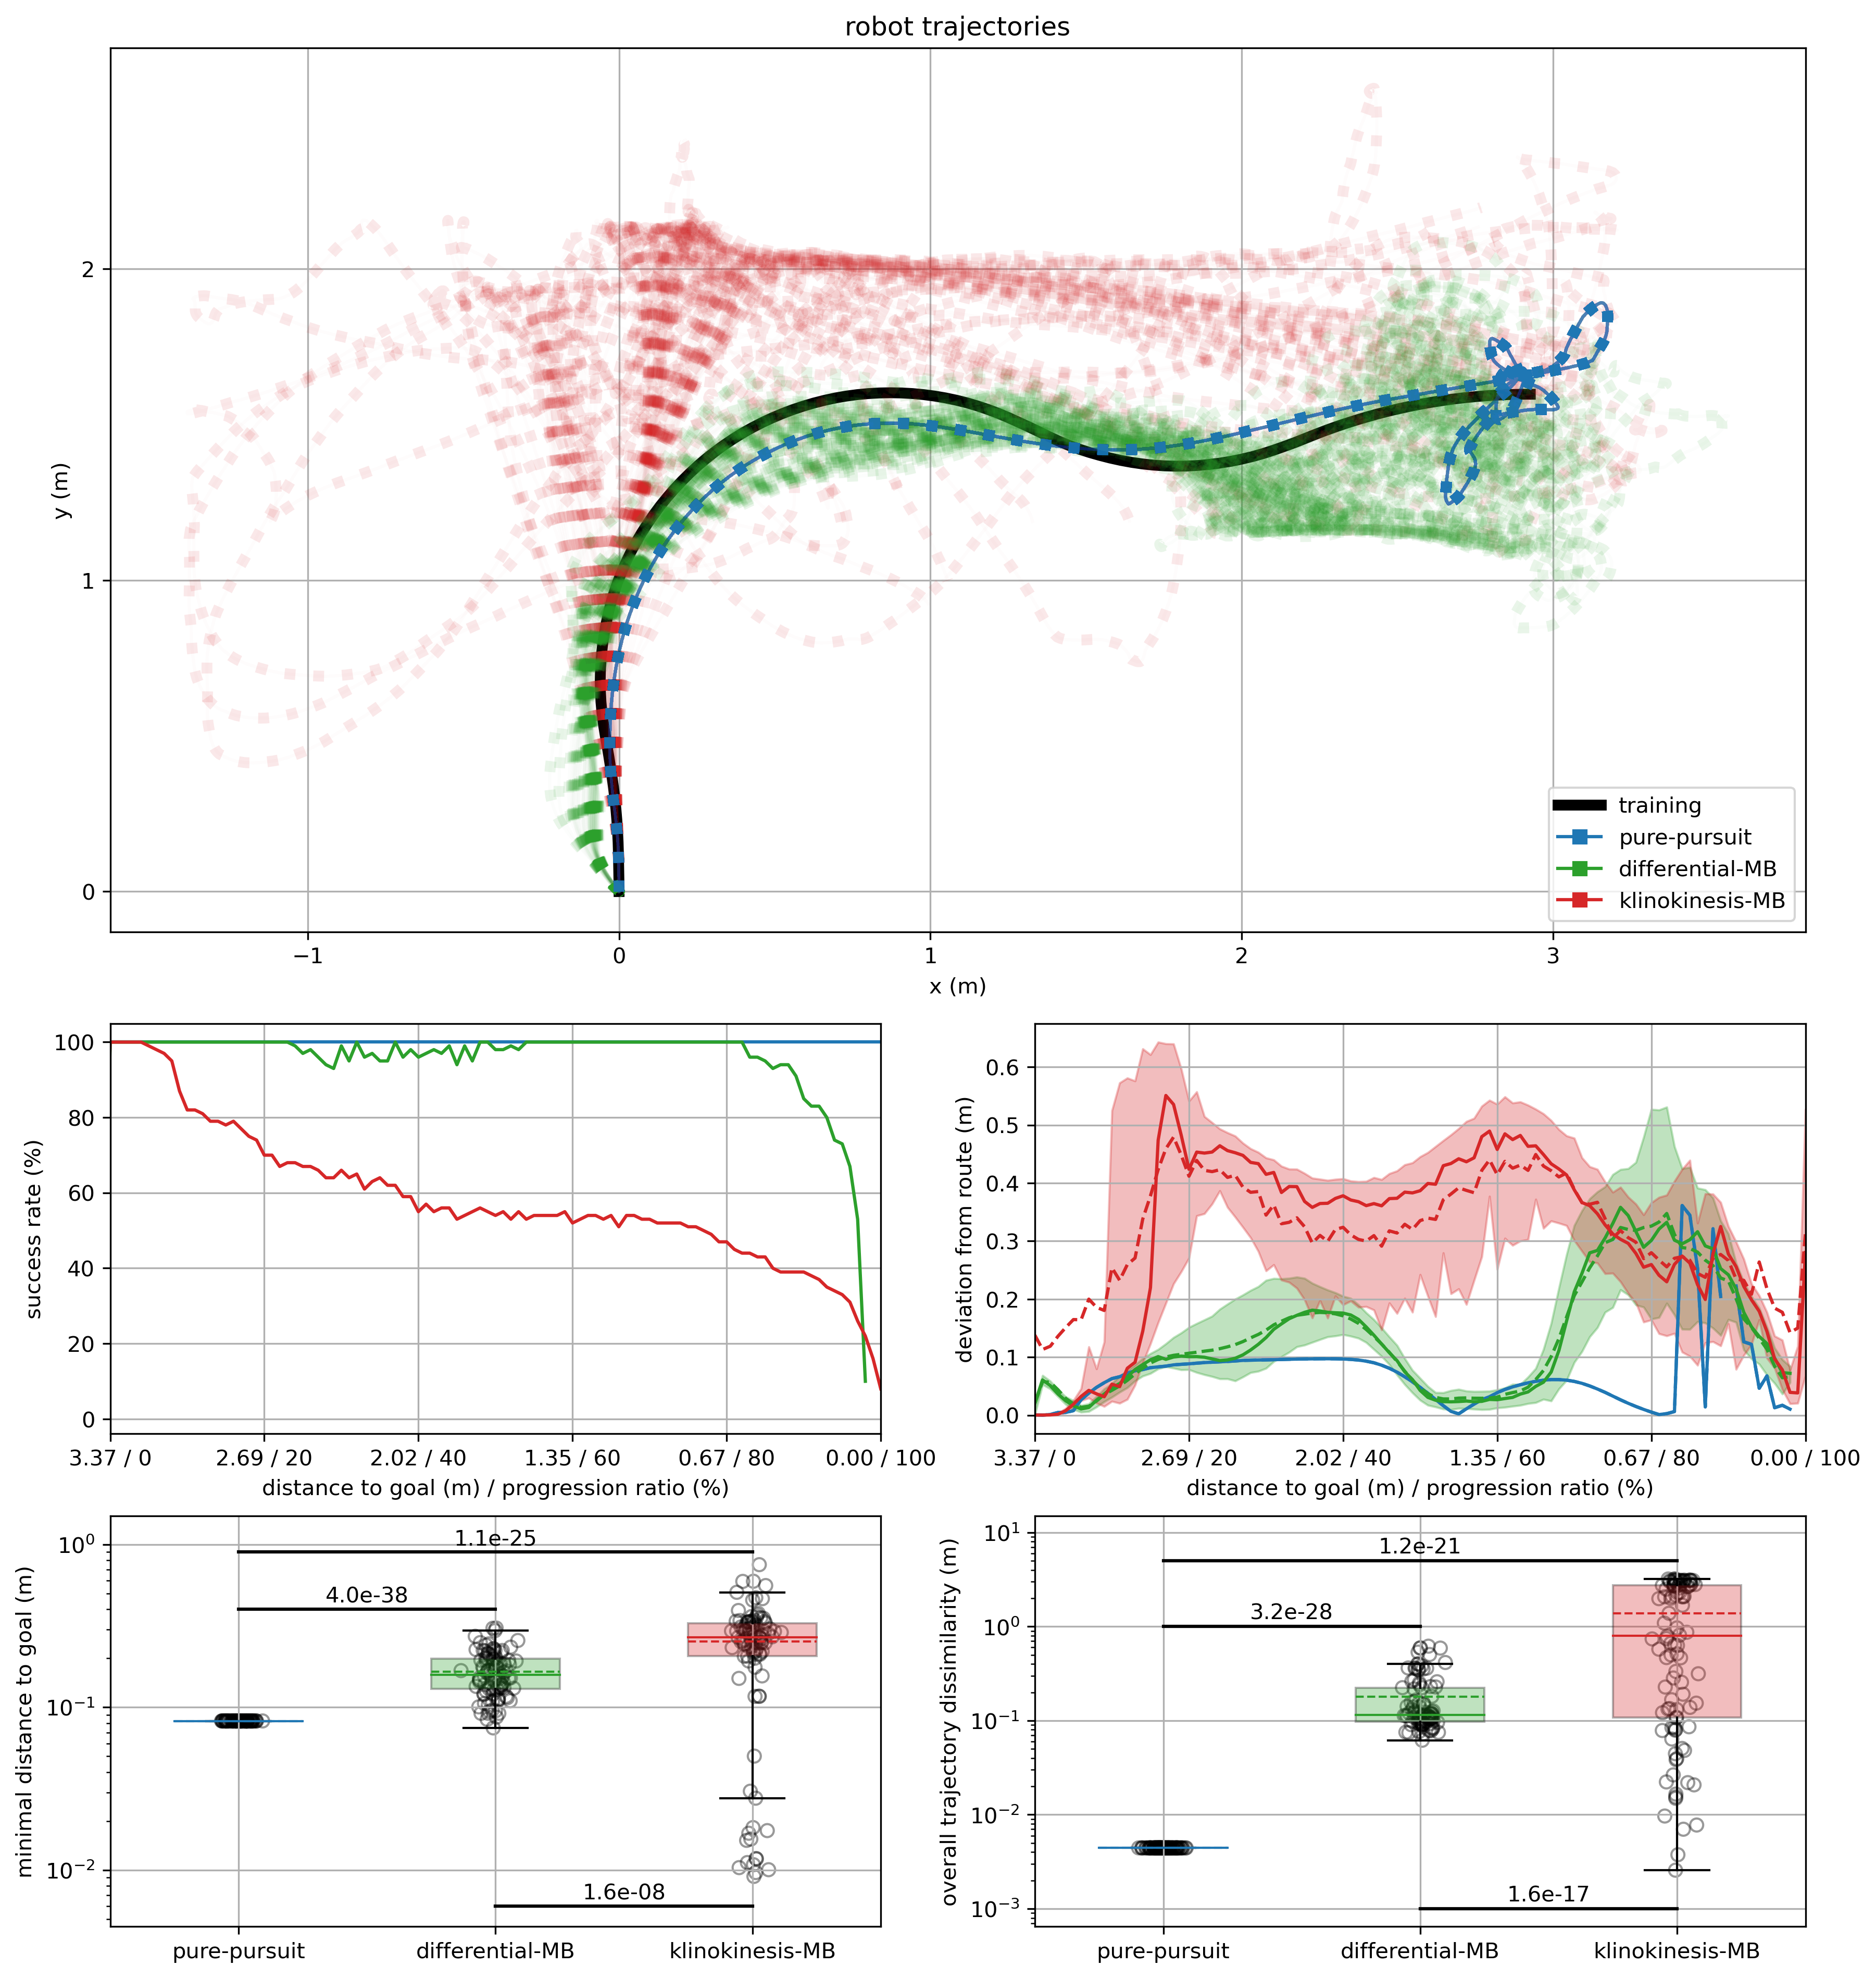

In [8]:
lw = 5

fig, axes = plt.subplot_mosaic('''
                                AA
                                AA
                                BC
                                DE''', figsize=(14, 16), dpi=300)

ls_validx = 3, 6, 4

# trajectory
ax = axes['A']

for model_name, color, validx in zip(ls_model_name, ls_color, ls_validx):
    if model_name == 'pure-pursuit':
        ax.plot(-path_train[:, :goal_idx][1], path_train[:, :goal_idx][0], c='k', label='training', lw=lw)
    ax.plot([], [], c=color, marker='s', label=model_name)


for model_name, color, validx in zip(np.flip(ls_model_name), np.flip(ls_color), np.flip(ls_validx)):
    dtp_train, dtp_test_trunc = [data_path[model_name][phase][validx] for phase in ('train', 'test_trunc')]
        
    for trial_idx, (path_train, path_test_trunc) in enumerate(zip(dtp_train, dtp_test_trunc)):
        if trial_idx % 1 == 0:
            ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.1, ls='dotted', lw=lw)
            ax.plot(-path_test_trunc[1], path_test_trunc[0], c=color, alpha=0.01)
    

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticks(np.arange(-1, 3.1, 1))
ax.set_yticks(np.arange(0, 2.1, 1))
ax.set_aspect('equal')    
ax.legend(loc=4)
ax.grid()
ax.set_title('robot trajectories')



# progression
bx, ax = axes['B'], axes['C']
for model_name, color, validx in zip(ls_model_name, ls_color, ls_validx):
    dist_test2goal, dist_test2path = data_dist_test2goal[model_name][validx], data_dist_test2path[model_name][validx]
    progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
    progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

    val_test2path, val_n_point = [], []
    val_ptime = []
    for trial_progress, trial_test2path in zip(progress, dist_test2path):
        px, pxidx, pxinv = np.unique(trial_progress, return_index=True, return_inverse=True)
        pxinvsort = np.argsort(pxinv)
        t2p_interp = np.interp(progress_step, pxinv[pxinvsort], trial_test2path[pxinvsort], left=np.nan, right=np.nan)
        val_test2path.append(t2p_interp)
        val_n_point.extend(px)

        ptime = np.full_like(progress_step, np.nan)
        ptime[(px[~np.isnan(px)] - np.min(progress_step)).astype(int)] = pxidx[~np.isnan(px)]
        val_ptime.append(ptime)


    ax.plot(progress_step, np.nanmean(val_test2path, axis=0), color=color, ls='dashed')
    ax.plot(progress_step, np.nanmedian(val_test2path, axis=0), color=color)

    ax.fill_between(progress_step, *np.nanquantile(val_test2path, (0.25, 0.75), axis=0), color=color, alpha=0.3)

    p_reach, n_reach = np.unique(val_n_point, return_counts=True)
    bx.plot(p_reach, n_reach, color=color, label=model_name)

    
str_xticklabel = ['{:.2f} / {}'.format(dist, rt) for dist, rt in zip(np.linspace(dist_init2goal[0, -1], 0, 6), np.arange(0, 101, 20))]
for ak, yl in zip('BC', ('success rate (%)', 'deviation from route (m)')):
    ax = axes[ak]
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20), str_xticklabel)
    ax.set_ylabel(yl)
    ax.grid()
    ax.set_xlabel('distance to goal (m) / progression ratio (%)')


# comparison
comparison_index = np.array([[0, 1], [0, 2], [1, 2]])
data_pval = []
for ak, alldata in zip('DE', (data_dsim_test2train, data_min_dist2goal)):
    ax = axes[ak]
    data = [alldata[model_name][validx] for model_name, validx in zip(ls_model_name, ls_validx)]
    myboxplot(ax, data, ls_model_name, ls_color, 0.4)
    pvalues = myttests(data, comparison_index, ispaired=False)
    data_pval.append(pvalues)
    mmm = [np.mean(d) for d in data]
    print(mmm[2] / mmm[1])

        
for ak, yl, ylim in zip('DE', ('minimal distance to goal (m)', 'overall trajectory dissimilarity (m)'), ((0.0045, 1.5), (0.00065, 15))):
    ax = axes[ak]
    ax.set_yscale('log')
    ax.set_ylabel(yl)
    ax.set_ylim(*ylim)
    ax.grid()
    
for ak, pvalues, h, ys in zip('DE', data_pval, (1.1, 1.2), ((0.4, 0.9, 0.006), (1, 5, 0.001))):
    ax = axes[ak]
    for pval, y, (xa, xb) in zip(pvalues, ys, comparison_index + 1):
        ax.plot([xa, xb], [y, y], color='k')
        if pval == 0:
            plabel = 'e.s.'
        elif pval <= 0.05:
            plabel = '{:.1e}'.format(pval)
        else:
            plabel = 'n.s.'
        ax.text((xa + xb) / 2, y * h, plabel, horizontalalignment='center')

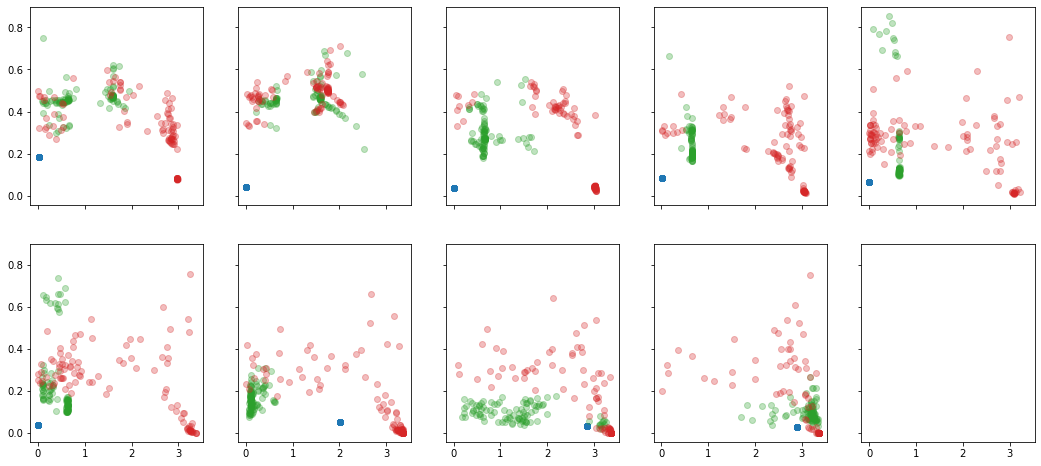

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)

n_catch = []

for model_name, color in zip(ls_model_name, ls_color):
    for ax, dsim_val, mind_val, in zip(axes.flatten(), data_dsim_test2train[model_name], data_min_dist2goal[model_name]):
        ax.scatter(mind_val, dsim_val, color=color, alpha=0.3)
        n_catch.append(np.count_nonzero(mind_val <= catchment_radius))
        
# for ax in axes.flatten():
#     ax.set_xscale('log')
#     ax.axvline(catchment_radius)
#     ax.set_yscale('log')

n_catch = np.reshape(n_catch, (n_model, n_condition))

/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-10-be9eae859fc2>:6: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(data, axis=1)
/home/yihelu/miniconda3/envs/python3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-10-be9eae859fc2>:6: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(data, axis=1)


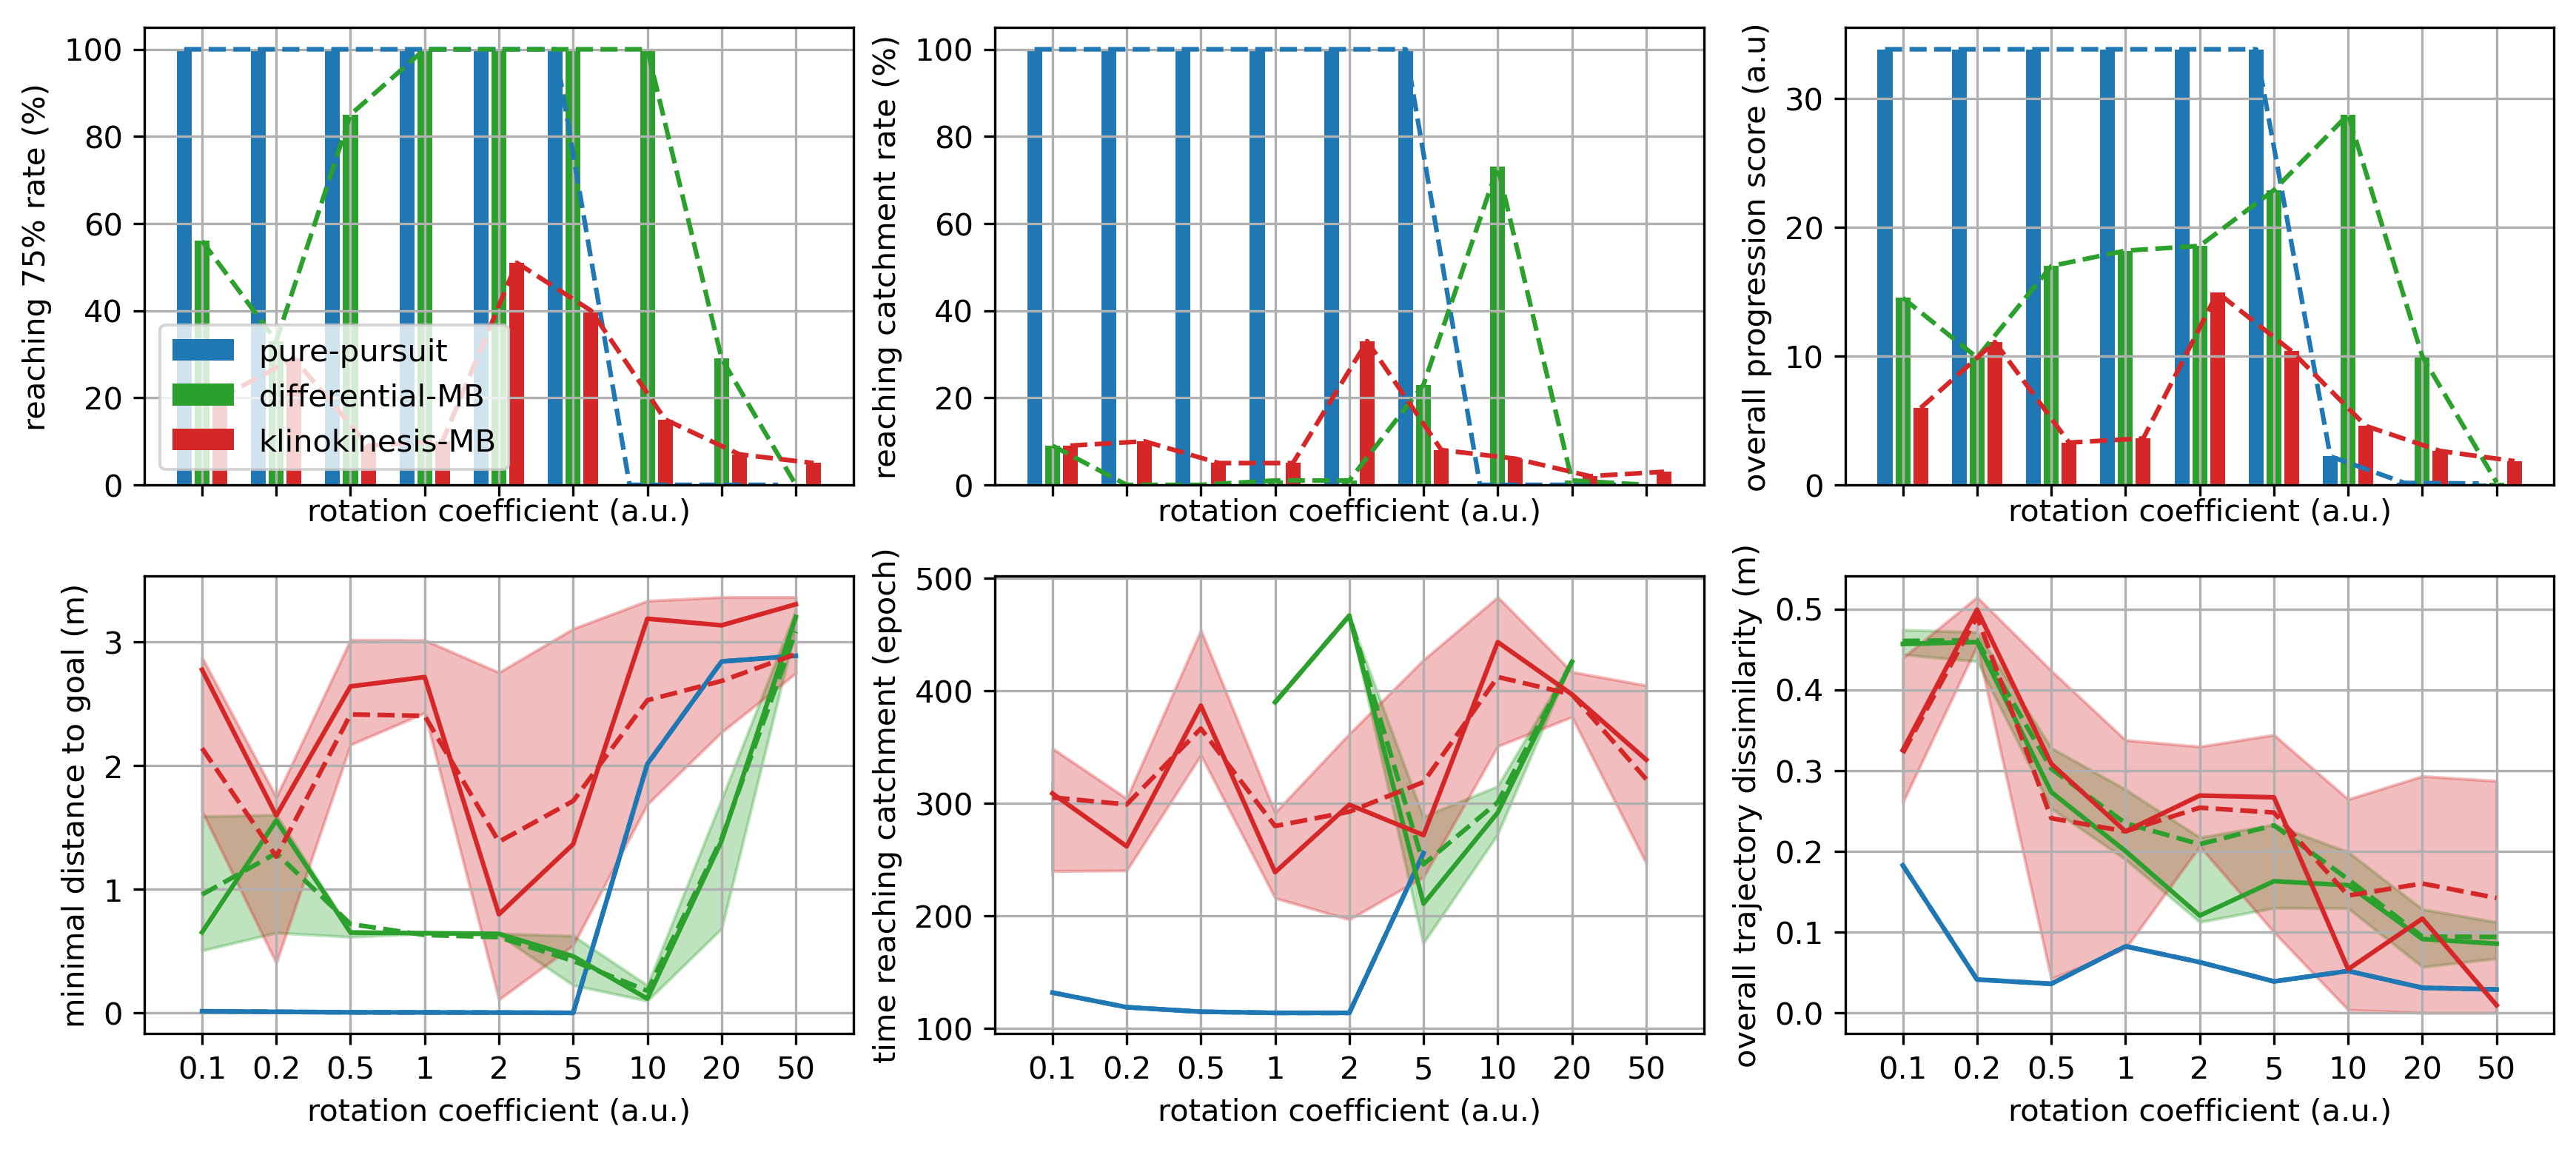

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True, dpi=300)

for model_name, color in zip(ls_model_name, ls_color):
    for ax, data in zip(axes[1], (data_min_dist2goal[model_name], data_time_catchment[model_name], data_dsim_test2train[model_name])):
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
        ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)


for xoffset, model_name, color, nc in zip(np.arange(n_model) - n_model / 2 + 0.5, ls_model_name, ls_color, n_catch):
    area_success, n_reach_75 = [], []
    for dist_test2goal, dist_test2path in zip(data_dist_test2goal[model_name], data_dist_test2path[model_name]):
        progress = np.rint((1 - np.divide(dist_test2goal.T, dist_test2goal[:, 0]).T) * 100)
        progress_step = np.arange(np.nanmin(progress), np.nanmax(progress) + 1)

        val_n_point = []
        for trial_progress in progress:
            px = np.unique(trial_progress)
            val_n_point.extend(px)

        p_reach, n_reach = np.unique(val_n_point, return_counts=True)
        
        p_reach_75idx = np.nonzero(p_reach >= 75)[0]
        if len(p_reach_75idx) > 0:
            n_reach_75.append(n_reach[p_reach_75idx[0]])
        else:
            n_reach_75.append(0)
        
        p_reach_posidx = np.nonzero(p_reach > 0)
        n_reach_pos = np.interp(np.arange(101), p_reach[p_reach_posidx], n_reach[p_reach_posidx], left=100, right=0)
        
#         area_success.append(np.dot(np.arange(101) / 100, n_reach_pos / 100))
        area_success.append(np.dot((np.arange(101) / 100) ** 2, n_reach_pos / 100))
        
    wd = 0.6 / n_model
    xbar = np.arange(n_condition) + xoffset * wd * 1.5
    xbar = np.arange(n_condition) + xoffset * (wd + 0.04)
    for ax, yy in zip(axes[0], (n_reach_75, nc, area_success)):
        ax.bar(xbar, yy, label=model_name, width=wd, color=color)
        ax.plot(xbar, yy, ls='dashed', color=color)
    
for ax, yl in zip(axes.flatten(), 
                  ('reaching 75% rate (%)', 
                   'reaching catchment rate (%)', 
                   'overall progression score (a.u)',
                   'minimal distance to goal (m)', 
                   'time reaching catchment (epoch)',
                   'overall trajectory dissimilarity (m)')):
    ax.set_ylabel(yl)
    
# for ax in axes[:-1]:
#     ax.set_ylim(top=102)

for ax in axes.flatten():
    ax.grid()
    ax.set_xticks(np.arange(n_condition), ls_value)
#     ax.set_xlabel('noise level (a.u.)')
    ax.set_xlabel('rotation coefficient (a.u.)')
    
# for ax in axes.T[0]:
axes[0, 0].legend(loc=3)
# axes[1, 2].set_yticks([0.05, 0.1, 0.15])

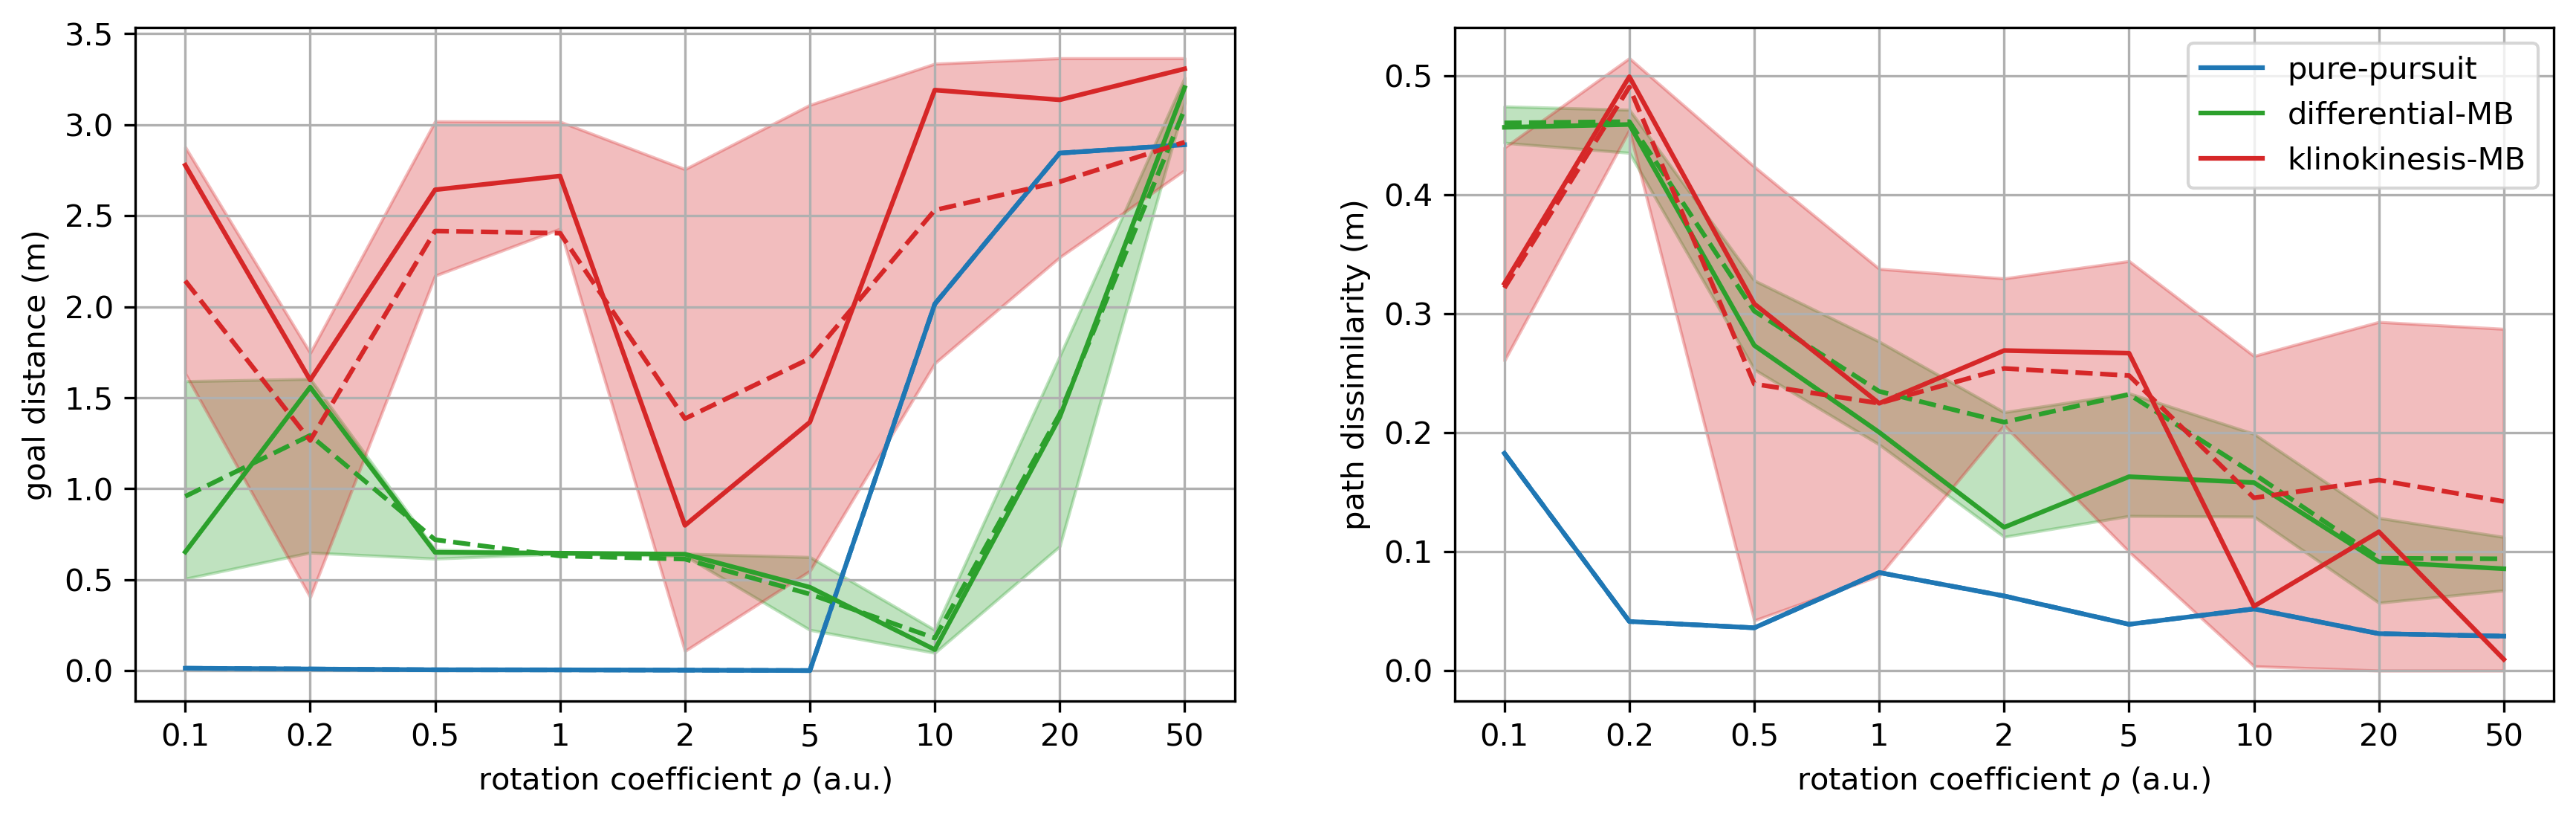

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, dpi=300)

for model_name, color in zip(ls_model_name, ls_color):
    for ax, data in zip(axes, (data_min_dist2goal[model_name], data_dsim_test2train[model_name])):
        quant = np.nanquantile(data, (0.25, 0.5, 0.75), axis=1)
        avg = np.nanmean(data, axis=1)
        ax.plot(np.arange(n_condition), avg, color=color, ls='dashed')
        ax.plot(np.arange(n_condition), quant[1], color=color, label=model_name)
        ax.fill_between(np.arange(n_condition), quant[0], quant[2], color=color, alpha=0.3)

    
for ax, yl in zip(axes.flatten(), 
                  ('goal distance (m)', 'path dissimilarity (m)')):
    ax.set_ylabel(yl)
    ax.grid()
    ax.set_xticks(np.arange(n_condition), ls_value)
    ax.set_xlabel(r'rotation coefficient $\rho$ (a.u.)')

axes[1].legend()